# 1. Regression and out-of-distribution prediction

# 1 A


a. Download the wine quality datasets from https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [ ]:
! pip -q install ucimlrepo shap

from warnings import filterwarnings as fw; fw('ignore')
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

#set seed
seed=69

wine_quality=fetch_ucirepo(id=186)
var=wine_quality.variables
df=wine_quality.data.original


df_white=df[df['color']=='white'].drop('color', axis=1).reset_index(drop=True)
df_red= df[df['color']=='red'].drop('color', axis=1).reset_index(drop=True)


print(f'Rows:{len(df)}[Red: {len(df_red)} and White: {len(df_white)}]')
print(var[['name', 'role', 'type', 'missing_values']])
df.head(5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.2 MB/s eta 0:00:00
Rows:6497[Red: 1599 and White: 4898]
                    name     role         type missing_values
0          fixed_acidity  Feature   Continuous             no
1       volatile_acidity  Feature   Continuous             no
2            citric_acid  Feature   Continuous             no
3         residual_sugar  Feature   Continuous             no
4              chlorides  Feature   Continuous             no
5    free_sulfur_dioxide  Feature   Continuous             no
6   total_sulfur_dioxide  Feature   Continuous             no
7                density  Feature   Continuous             no
8                     pH  Feature   Continuous             no
9              sulphates  Feature   Continuous             no
10               alcohol  Feature   Continuous             no
11               quality   Target      Integer             no
12                 color    Other  Categorical             no


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


# 1 B


b.Explore, visualize and pre-process the data as appropriate.

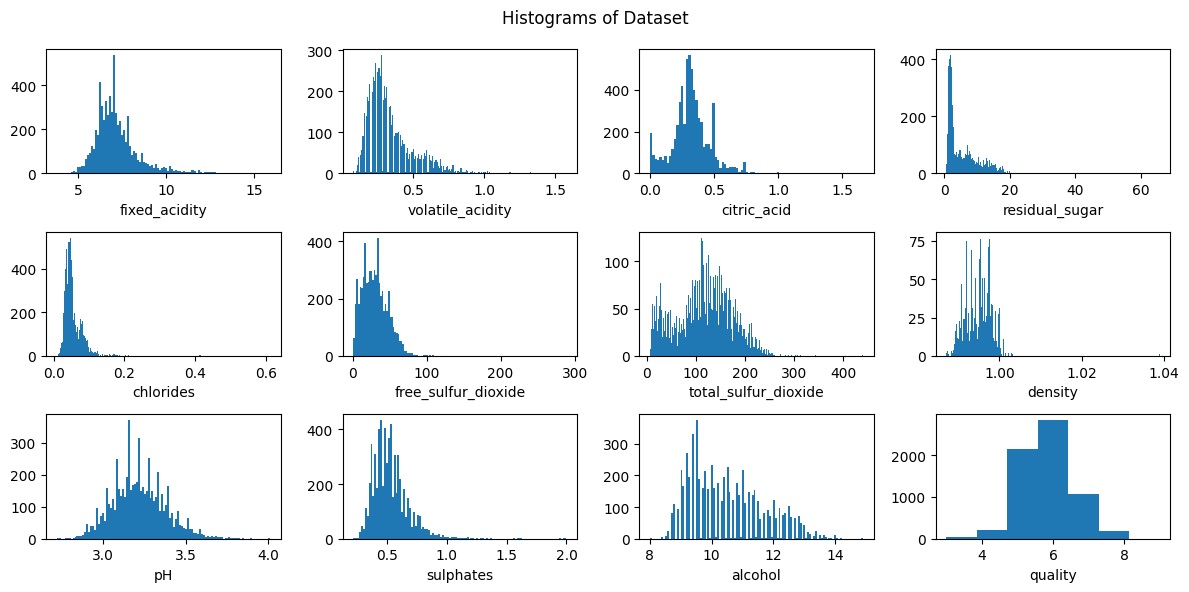

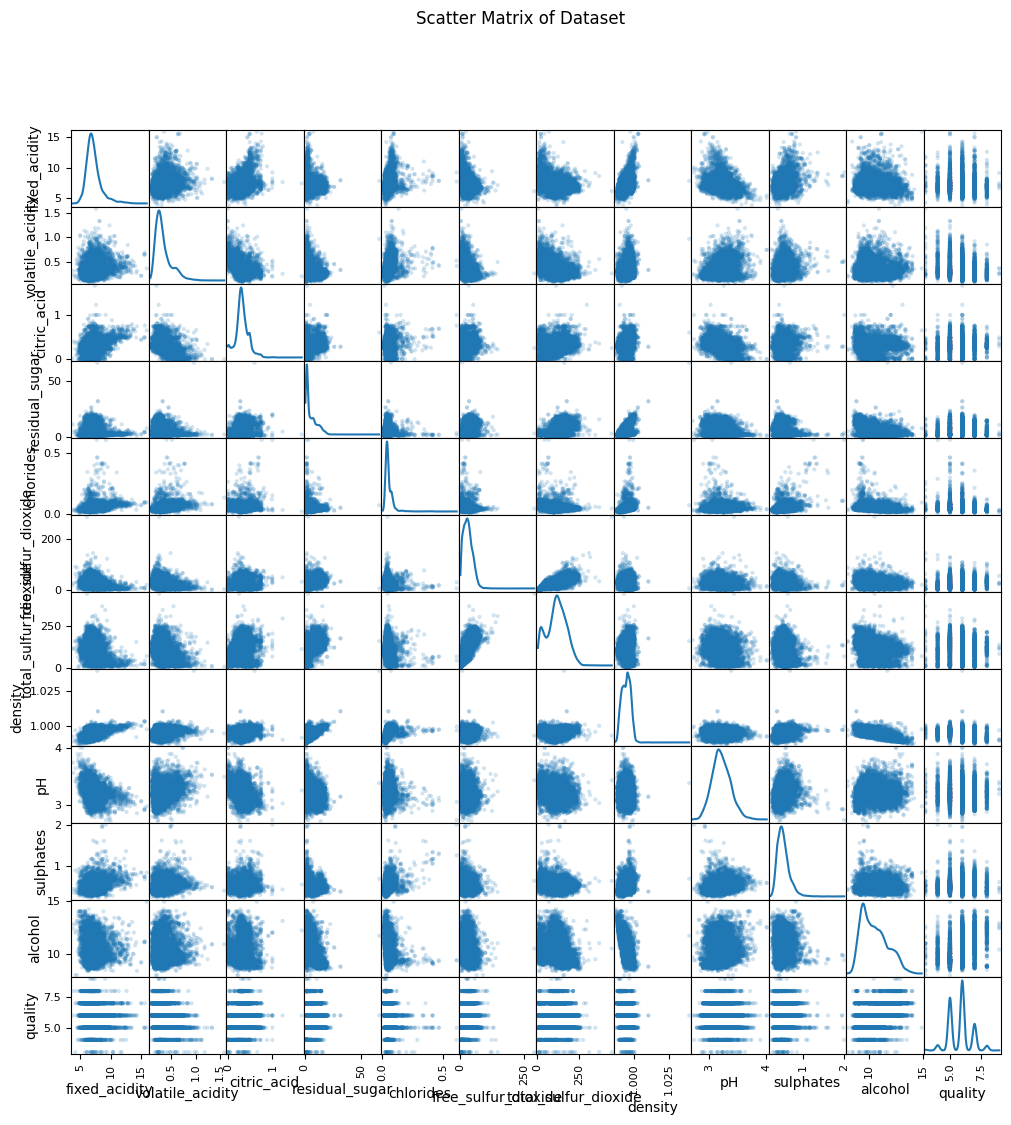

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame

fig, axes = plt.subplots(3, 4, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if df[col].dtype in [float, int]:
        axes[i].hist(df[col], bins=len(pd.unique(df[col])))
        axes[i].set_xlabel(col)

fig.suptitle('Histograms of Dataset')
plt.tight_layout()
plt.show()

from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.suptitle('Scatter Matrix of Dataset')
plt.show()


Highly correlated features: set()


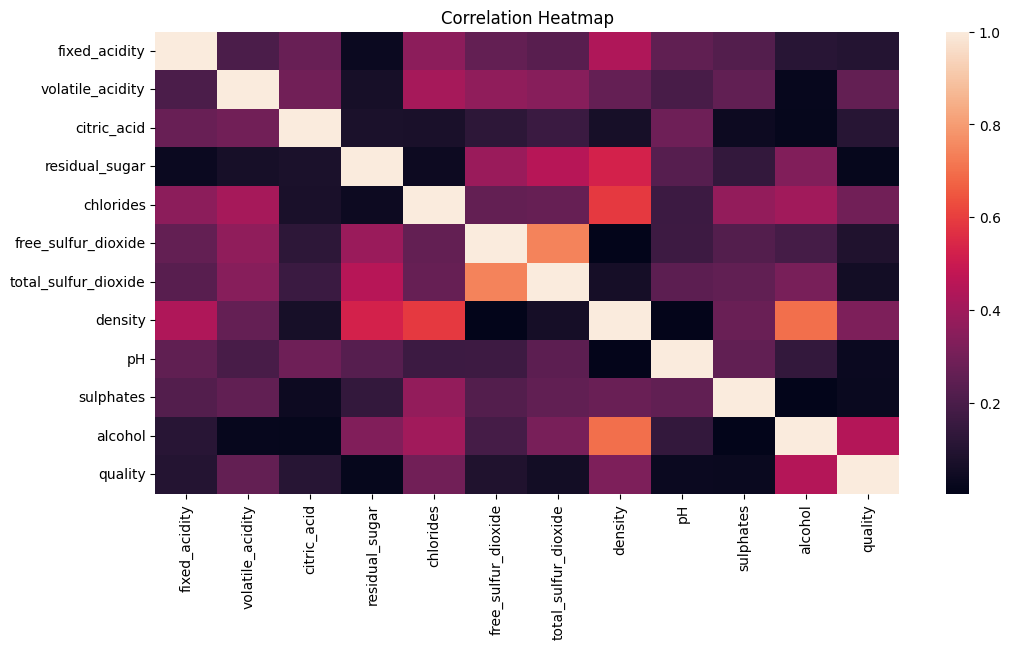

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))

# Calculate the correlation matrix using Spearman method
corrMatrix = df.corr(method='spearman')

# Create a heatmap of absolute correlation values
sns.heatmap(abs(corrMatrix), annot=False)

# Find highly correlated features
high_corr_vars = set()
for i in range(len(corrMatrix.columns)):
    for j in range(i):
        if abs(corrMatrix.iloc[i, j]) > 0.8:
            high_corr_vars.add(corrMatrix.columns[i])
            high_corr_vars.add(corrMatrix.columns[j])

# Print highly correlated features
print(f'Highly correlated features: {high_corr_vars}')

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

Observation: It seems that no feature is highly correlated


# 1 C


1.c Train, validate varying at least one hyperparameter, and test at least two types of models: [2]i. Random forest ii. Support vector regression with RBF kernel iii. Neural network with single hidden layer (output layer should have linear activation)

RED DATASET PROCESSING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x=df_red.drop('quality', axis=1) #get features
y=df_red['quality'] #get target

#split data into temporary dataset and holdout dataset(80%train, 20%holdout)
x_train, x_holdout, y_train, y_holdout =train_test_split(x, y, test_size=0.2, random_state=seed)

#split holdout dataset into validation and test datasets (50%validation, 50%test of pending 20%)
x_val, x_test, y_val, y_test= train_test_split(x_holdout, y_holdout, test_size=0.5, random_state=seed)

#Normalize X_train
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)

#Transform x_val and x_test using the same scaler
x_val=scaler.transform(x_val)
x_test=scaler.transform(x_test)

x_red_test, y_red_test=x_test, y_test

#verify the shapes of the resulting sets
print("training set shape:", x_train.shape)
print("validation set shape:", x_val.shape)
print("test set shape:",x_test.shape)


training set shape: (1279, 11)
validation set shape: (160, 11)
test set shape: (160, 11)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

#define models
models={
    "Random Forest":RandomForestRegressor(),
    "SVR with RBF kernel":SVR(kernel='rbf'),
    "Neural Network":MLPRegressor(max_iter=1000, activation='identity')
}

#define hyperparameters to varry and search over
params={
    "Random Forest":{"n_estimators":[50,100,200]},
    "SVR with RBF kernel": {"C":[0.1,1,10], "gamma":['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,),], "alpha":[0.0001, 0.001, 0.01]}
}

#train, validate and test models
for name, model in models.items():
  print(f"training and tuning {name}...")

  #perform gridsearchCV for hyperparameter tuning
  grid_search=GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error',)
  grid_search.fit(x_train, y_train)

  #get best estimator
  best_model=grid_search.best_estimator_
  models[name]=best_model

  #train
  y_train_pred=best_model.predict(x_train)
  train_mse=mean_squared_error(y_train, y_train_pred)
  print(f"Training MSE:{train_mse}")

  #validate
  y_val_pred=best_model.predict(x_val)
  val_mse=mean_squared_error(y_val, y_val_pred)
  print(f"Validation MSE:{val_mse}")

  #test
  y_test_pred=best_model.predict(x_test)
  test_mse=mean_squared_error(y_test, y_test_pred)
  print(f"Test MSE:{test_mse}\n")

model_red=models['Random Forest']

training and tuning Random Forest...
Training MSE:0.047987724784988264
Validation MSE:0.349180625
Test MSE:0.35955

training and tuning SVR with RBF kernel...
Training MSE:0.2921834435599441
Validation MSE:0.4334442292580234
Test MSE:0.41510386249104714

training and tuning Neural Network...
Training MSE:0.4050291463476011
Validation MSE:0.4638071407633248
Test MSE:0.48231151035961767



Observation:

We used gridsearch CV to tune the hyperparameters for the best model with least error
1) Least testing error is in Random forest model
2)Most testing is in Neural Network might be due to the smaller data size, roughly 1500 entries.


#1 D


d. Search the net about how to determine the importance of each variable, and find the importance in the final models tried. Comment on whether the same variables are important for different models. [1]


In [ ]:
from sklearn.inspection import permutation_importance
import shap

feature_weights= lambda y: sorted(zip(df_red.columns, y/sum(y)), key=lambda x:x[1], reverse=True) #sorting features based on weights

rf_importances =np.abs(models['Random Forest'].feature_importances_)
svr_coefs =np.abs(permutation_importance (models['SVR with RBF kernel'], x_train, y_train, random_state=seed).importances_mean)#using permu_impor
nn_coefs=np.abs(shap.Explainer(models['Neural Network'].predict, x_train).shap_values(x_train)).mean(axis=0) #using shap


print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
  print(f"{i}:{importance}")

print("\nSVR Feature Importances:")
for i, importance in feature_weights(svr_coefs):
  print(f"{i}:{importance}")

print("\nNeural Network Feature Importances:")
for i, importance in feature_weights(nn_coefs):
  print(f"{i}:{importance}")





PermutationExplainer explainer: 1280it [00:16, 39.04it/s]                           


Random Forest Feature Importances:
alcohol:0.27504725883637854
sulphates:0.13325457202582092
volatile_acidity:0.12898802404004261
total_sulfur_dioxide:0.08980964417278822
chlorides:0.07092111186641703
pH:0.05635023325268889
density:0.05437803176172685
residual_sugar:0.05216799360670058
fixed_acidity:0.049364876942748194
citric_acid:0.047209762311289795
free_sulfur_dioxide:0.04250849118339831

SVR Feature Importances:
alcohol:0.2438489037526999
sulphates:0.15431048299762473
volatile_acidity:0.14053530165127992
total_sulfur_dioxide:0.09624966654022467
pH:0.06686181072448653
citric_acid:0.06562524562008032
fixed_acidity:0.06544998320564603
density:0.05003873511868793
free_sulfur_dioxide:0.04812935279778343
residual_sugar:0.03701175825283335
chlorides:0.031938759338653165

Neural Network Feature Importances:
alcohol:0.2880895929211387
volatile_acidity:0.1874591673069091
sulphates:0.13440805894910599
total_sulfur_dioxide:0.10490458971930379
density:0.06477035479385193
pH:0.06271447398837618

Observations:

1) Consistent importance of features:
*   "Alcohol" is a trait that is consistently present in all models.
*  The importance of "sulphates," "volatile acidity," and "total sulfur dioxide" is likewise consistently high among models.

2)Differing priority rankings:


*  Even though some features are always important, different models may order them significantly differently.

* The relative relevance of "chlorides" and "residual sugar" varies.


3)Variations in the Significance of Features:

*   Certain features, such as "citric acid," "density," and "fixed acidity," show variation in significance amongst models.

4) Patterns of Model-Specific Importance:


*  Because each model has a particular algorithm, it may stress some aspects more than others. Among other models, the random forest model gives 'total sulfur dioxide' a lower priority.

5) General Uniformity in Significant Elements:



*  Considerable characteristics recurrently show up as significant indicators of wine quality across various modeling techniques, despite considerable variances. This implies that characteristics like "alcohol," "sulphates," and "volatile acidity" are robustly important.











WHITE DATASET PROCESSING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x=df_white.drop('quality', axis=1) #get features
y=df_white['quality'] #get target

#split data into temporary dataset and holdout dataset(80%train, 20%holdout)
x_train, x_holdout, y_train, y_holdout =train_test_split(x, y, test_size=0.2, random_state=seed)

#split holdout dataset into validation and test datasets (50%validation, 50%test of pending 20%)
x_val, x_test, y_val, y_test= train_test_split(x_holdout, y_holdout, test_size=0.5, random_state=seed)

#Normalize X_train
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)

#Transform x_val and x_test using the same scaler
x_val=scaler.transform(x_val)
x_test=scaler.transform(x_test)

x_white_test, y_white_test=x_test, y_test

#verify the shapes of the resulting sets
print("training set shape:", x_train.shape)
print("validation set shape:", x_val.shape)
print("test set shape:",x_test.shape)


training set shape: (3918, 11)
validation set shape: (490, 11)
test set shape: (490, 11)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

#define models
models={
    "Random Forest":RandomForestRegressor(),
    "SVR with RBF kernel":SVR(kernel='rbf'),
    "Neural Network":MLPRegressor(max_iter=1000, activation='identity')
}

#define hyperparameters to varry and search over
params={
    "Random Forest":{"n_estimators":[50,100,200]},
    "SVR with RBF kernel": {"C":[0.1,1,10], "gamma":['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,),], "alpha":[0.0001, 0.001, 0.01]}
}

#train, validate and test models
for name, model in models.items():
  print(f"training and tuning {name}...")

  #perform gridsearchCV for hyperparameter tuning
  grid_search=GridSearchCV(model, params[name], cv=5, scoring='neg_mean_squared_error',)
  grid_search.fit(x_train, y_train)

  #get best estimator
  best_model=grid_search.best_estimator_
  models[name]=best_model

  #train
  y_train_pred=best_model.predict(x_train)
  train_mse=mean_squared_error(y_train, y_train_pred)
  print(f"Training MSE:{train_mse}")

  #validate
  y_val_pred=best_model.predict(x_val)
  val_mse=mean_squared_error(y_val, y_val_pred)
  print(f"Validation MSE:{val_mse}")

  #test
  y_test_pred=best_model.predict(x_test)
  test_mse=mean_squared_error(y_test, y_test_pred)
  print(f"Test MSE:{test_mse}\n")

model_white=models['Random Forest']

training and tuning Random Forest...
Training MSE:0.05210384124553344
Validation MSE:0.3851389795918368
Test MSE:0.3363790816326531

training and tuning SVR with RBF kernel...
Training MSE:0.3938663528630078
Validation MSE:0.49265410243751484
Test MSE:0.46077535355015087

training and tuning Neural Network...
Training MSE:0.5598493367147911
Validation MSE:0.6081185822710539
Test MSE:0.5600110570463546



In [ ]:
from sklearn.inspection import permutation_importance
import shap

feature_weights= lambda y: sorted(zip(df_white.columns, y/sum(y)), key=lambda x:x[1], reverse=True) #sorting features based on weights

rf_importances =np.abs(models['Random Forest'].feature_importances_)
svr_coefs =np.abs(permutation_importance (models['SVR with RBF kernel'], x_train, y_train, random_state=seed).importances_mean)#using permu_impor
nn_coefs=np.abs(shap.Explainer(models['Neural Network'].predict, x_train).shap_values(x_train)).mean(axis=0) #using shap


print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
  print(f"{i}:{importance}")

print("\nSVR Feature Importances:")
for i, importance in feature_weights(svr_coefs):
  print(f"{i}:{importance}")

print("\nNeural Network Feature Importances:")
for i, importance in feature_weights(nn_coefs):
  print(f"{i}:{importance}")





PermutationExplainer explainer: 3919it [00:36, 75.85it/s]                           


Random Forest Feature Importances:
alcohol:0.24827850034824447
volatile_acidity:0.12730142620866533
free_sulfur_dioxide:0.1091542031334959
residual_sugar:0.0728700735756139
total_sulfur_dioxide:0.07108856473589086
pH:0.06949251708336521
density:0.06312444492410652
chlorides:0.06299205411736779
sulphates:0.05941087997081978
fixed_acidity:0.059090750761045065
citric_acid:0.05719658514138505

SVR Feature Importances:
density:0.21237245270868868
residual_sugar:0.12006192774162652
alcohol:0.11596514250508794
volatile_acidity:0.10401453087422008
pH:0.0904276656078282
total_sulfur_dioxide:0.07811837859395661
free_sulfur_dioxide:0.07102598542731292
citric_acid:0.061660072004660116
sulphates:0.05779636586807303
fixed_acidity:0.04704155900659229
chlorides:0.041515919661953615

Neural Network Feature Importances:
density:0.25736908580571766
residual_sugar:0.24089719481794103
alcohol:0.1812566342324371
volatile_acidity:0.10514759879499505
pH:0.0631540553481473
free_sulfur_dioxide:0.053058868634449

#1 E

e. Test the model for red with data from white and vice versa, and comment on whether the model for red wines is applicable to white wines and versa or not. [1]

In [ ]:
# Testing the red wine model with white wine data
y_pred_white = model_red.predict(x_white_test)

# Testing the white wine model with red wine data
y_pred_red = model_white.predict(x_red_test)

# Evaluating model performance
mse_red_with_white = mean_squared_error(y_white_test, y_pred_white)
mse_white_with_red = mean_squared_error(y_red_test, y_pred_red)

print("Mean Squared Error when evaluating red wine model with white wine data:", mse_red_with_white)
print("Mean Squared Error when evaluating white wine model with red wine data:", mse_white_with_red)


Mean Squared Error when evaluating red wine model with white wine data: 0.7697739795918368
Mean Squared Error when evaluating white wine model with red wine data: 0.589839375


Observations:
Using the Mean Squared Error (MSE) values that have been provided:

* Testing Red wine model on red wine data yielded an MSE of 0.34
* Testing white wine model on white wine data yielded an MSE of 0.33
* Testing red wine model on white wine data yielded an MSE of 0.77
* Testing white wine model on red wine data yielded an MSE of 0.60



# 2. Classification

# 2 A


a. Download the data to predict Down syndrome in mice from https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression#. The prediction problem is to either predict the genotype (binary) using the gene expression variables from DYRK1A_N to CaNA_N.

In [ ]:
#downloading and extracting the dataset
! rm -rf Data_Cortex_Nuclear.cls
! wget -q https://archive.ics.uci.edu/static/public/342/mice+protein+expression.zip
! unzip -q mice+protein+expression.zip
! rm -rf mice+protein+expression.zip
import pandas as pd
import numpy as np

df=pd.read_excel("Data_Cortex_Nuclear.xls") #reading dataset
df=df.drop(columns=['MouseID', 'Treatment', 'Behavior', 'Genotype']) #dropping irrelvant classes

x=df.drop('class',axis=1)
y=df['class']

print(len(x))
df.head()



1080


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.129954,NaN,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,c-CS-m


Observations:
1080 sample size with 77 characteristics as input. The goal is to classify eight classes, and certain aspects contain null values.

# 2 B

b. Explore, visualize, and pre-process the data as appropriate, including developing a strategy to deal with missing variables. You can choose to impute the variable. The recommended way is to use multivariate feature imputation (https://scikit-learn.org/stable/modules/impute.html) [1]

In [ ]:

import numpy as np

# Checking unique values and nulls for each column
for col in df.columns[:-1]:
    unique_values = df[col].unique()
    null_count = np.sum(df[col].isnull())
    print(f'{col}: {df[col].dtypes} type has {len(unique_values)} unique values with {null_count} nulls')


DYRK1A_N: float64 type has 1078 unique values with 3 nulls
ITSN1_N: float64 type has 1077 unique values with 3 nulls
BDNF_N: float64 type has 1078 unique values with 3 nulls
NR1_N: float64 type has 1078 unique values with 3 nulls
NR2A_N: float64 type has 1078 unique values with 3 nulls
pAKT_N: float64 type has 1077 unique values with 3 nulls
pBRAF_N: float64 type has 1076 unique values with 3 nulls
pCAMKII_N: float64 type has 1078 unique values with 3 nulls
pCREB_N: float64 type has 1078 unique values with 3 nulls
pELK_N: float64 type has 1078 unique values with 3 nulls
pERK_N: float64 type has 1078 unique values with 3 nulls
pJNK_N: float64 type has 1077 unique values with 3 nulls
PKCA_N: float64 type has 1078 unique values with 3 nulls
pMEK_N: float64 type has 1078 unique values with 3 nulls
pNR1_N: float64 type has 1078 unique values with 3 nulls
pNR2A_N: float64 type has 1078 unique values with 3 nulls
pNR2B_N: float64 type has 1078 unique values with 3 nulls
pPKCAB_N: float64 type

The task is to manage the null values; in a subsequent section, we'll employ an imputer for the same.

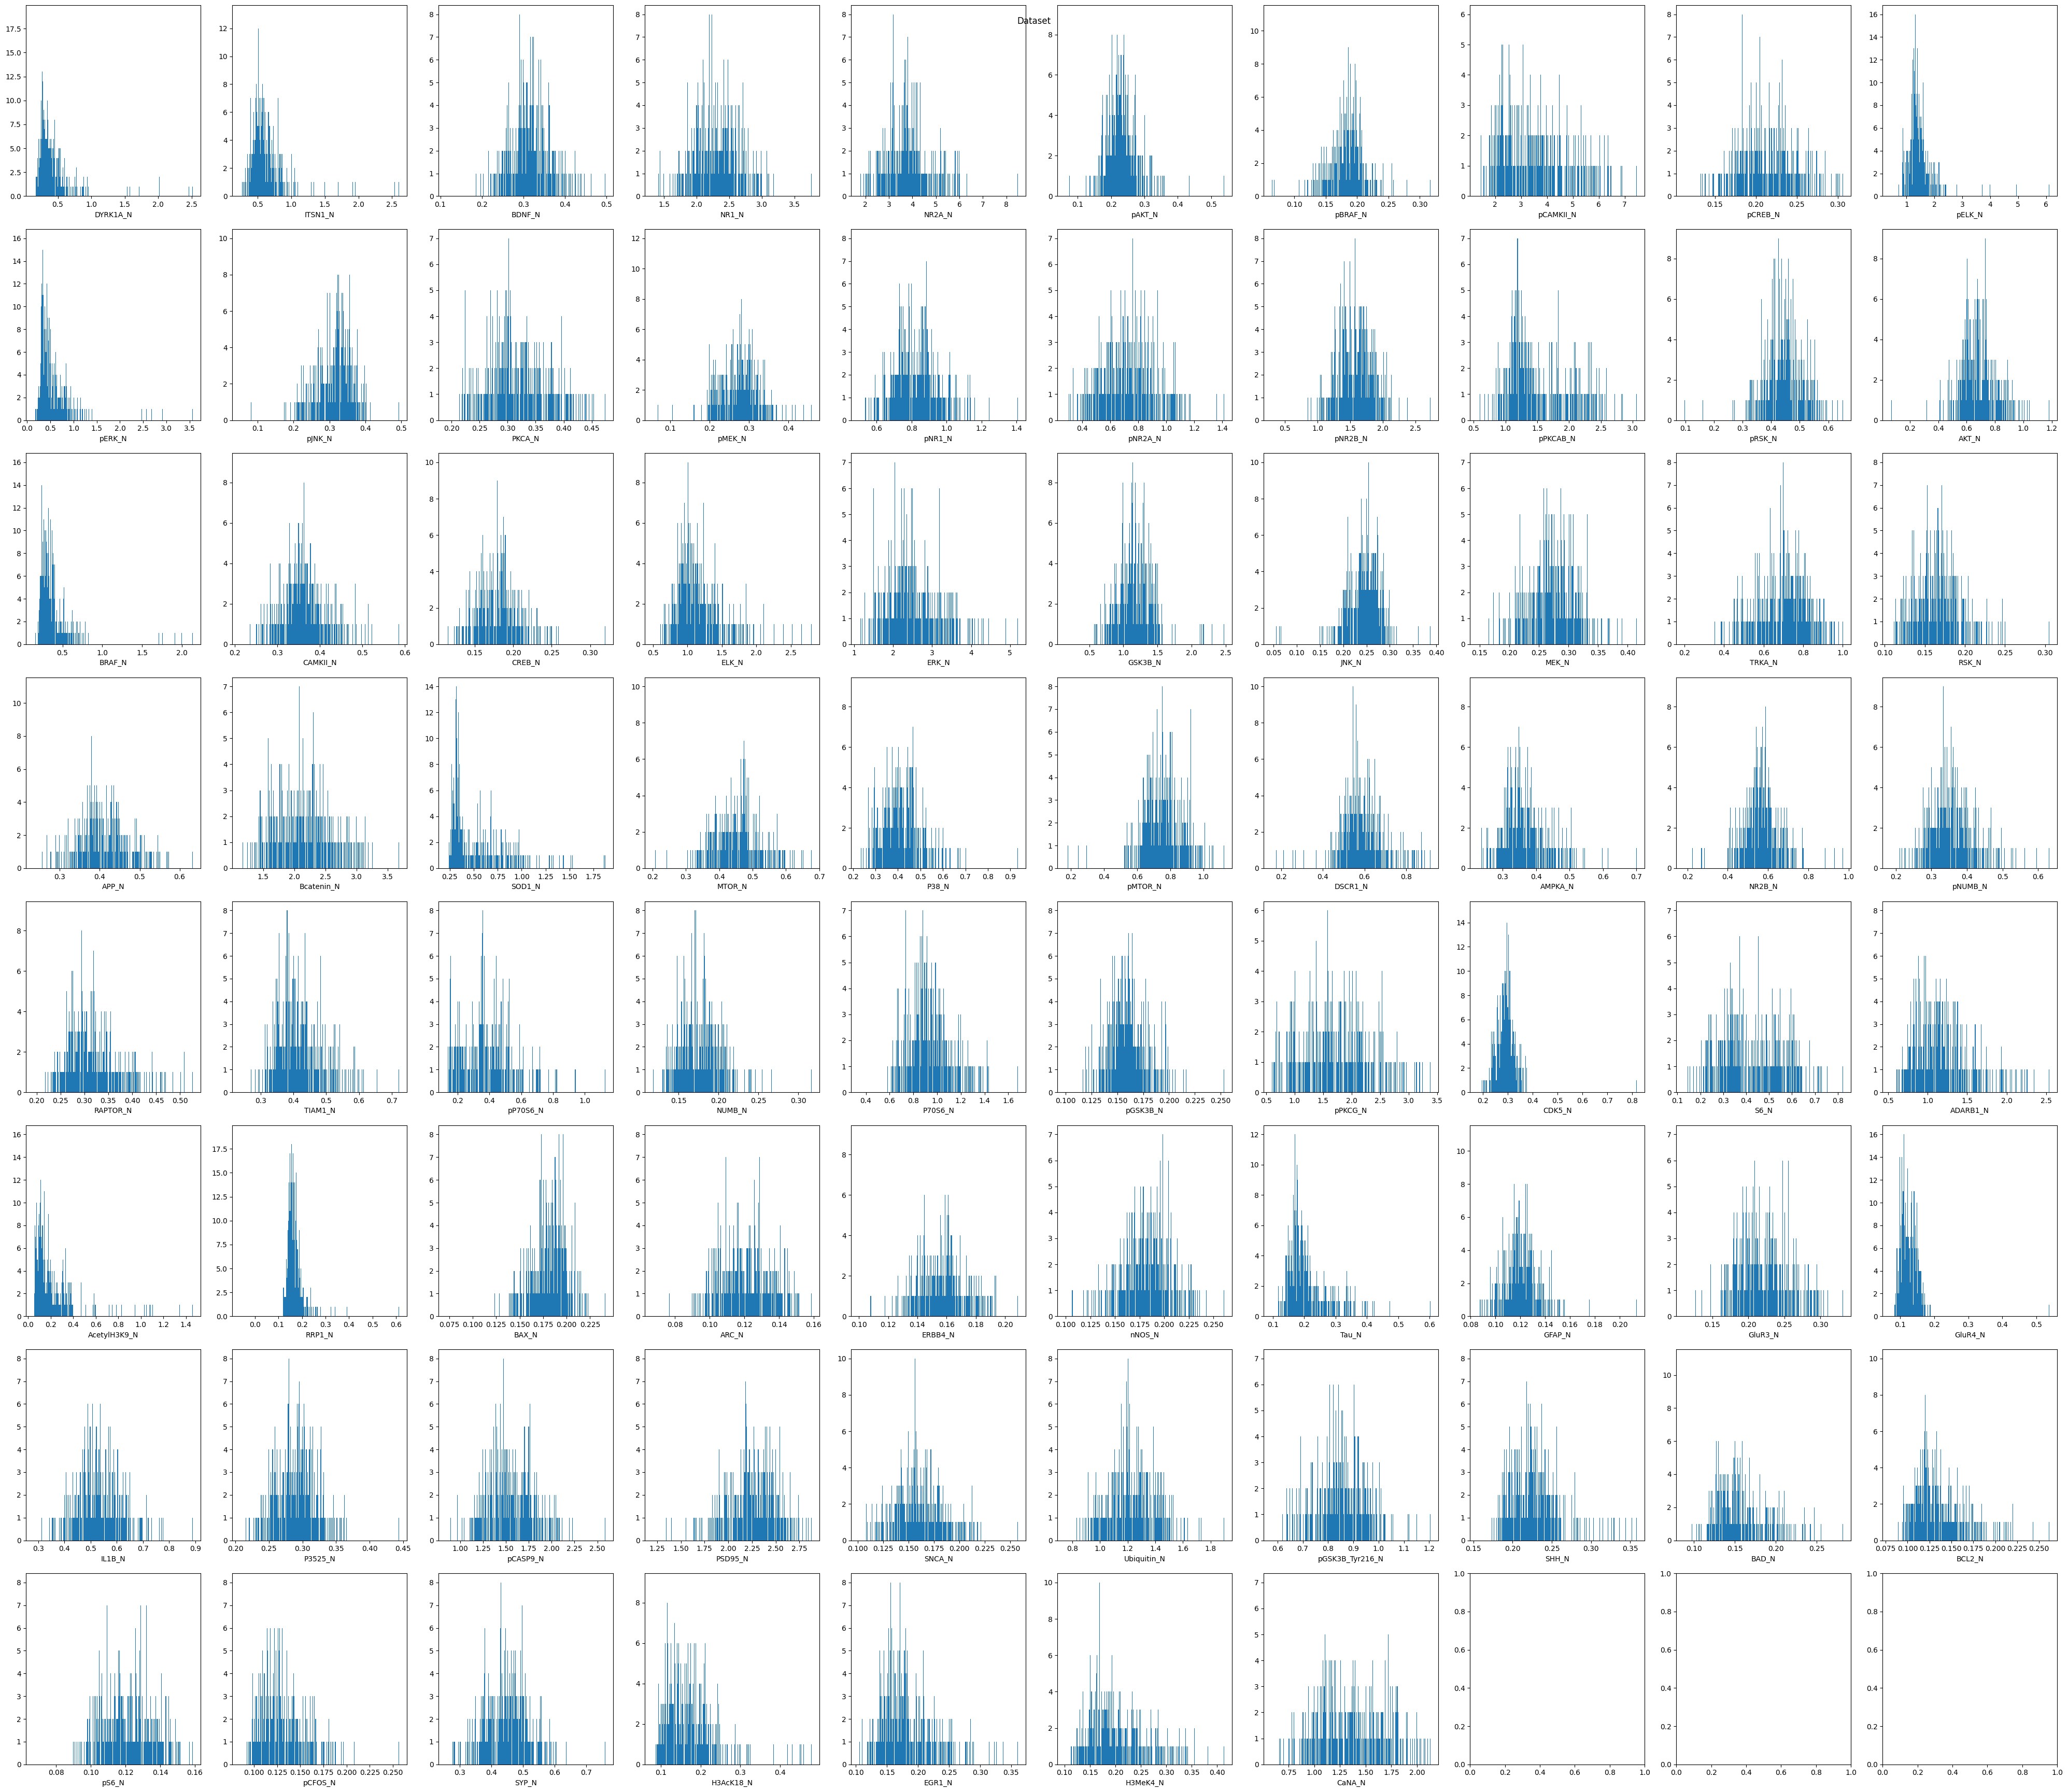

In [ ]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for subplots
num_rows = 8
num_cols = 10

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 35))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop over each column in the DataFrame
for i, col in enumerate(df.columns):
    # Plot only if the column is numeric
    if df[col].dtype in ['float64', 'int64']:
        # Plot histogram
        axes[i].hist(df[col], bins=len(pd.unique(df[col])))
        axes[i].set_xlabel(col)  # Set label for the current subplot

# Set title for the entire figure
fig.suptitle('Dataset')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


Highly correlated features: {'EGR1_N', 'TRKA_N', 'pMEK_N', 'pPKCAB_N', 'pNR1_N', 'pNR2B_N', 'ELK_N', 'BDNF_N', 'BCL2_N', 'NR2B_N', 'GSK3B_N', 'NR1_N', 'DYRK1A_N', 'ARC_N', 'pAKT_N', 'AMPKA_N', 'Bcatenin_N', 'H3MeK4_N', 'CREB_N', 'TIAM1_N', 'pJNK_N', 'MEK_N', 'BRAF_N', 'pERK_N', 'pS6_N', 'ERK_N', 'JNK_N', 'RSK_N', 'MTOR_N', 'NR2A_N', 'PKCA_N', 'ITSN1_N', 'pBRAF_N', 'H3AcK18_N'}


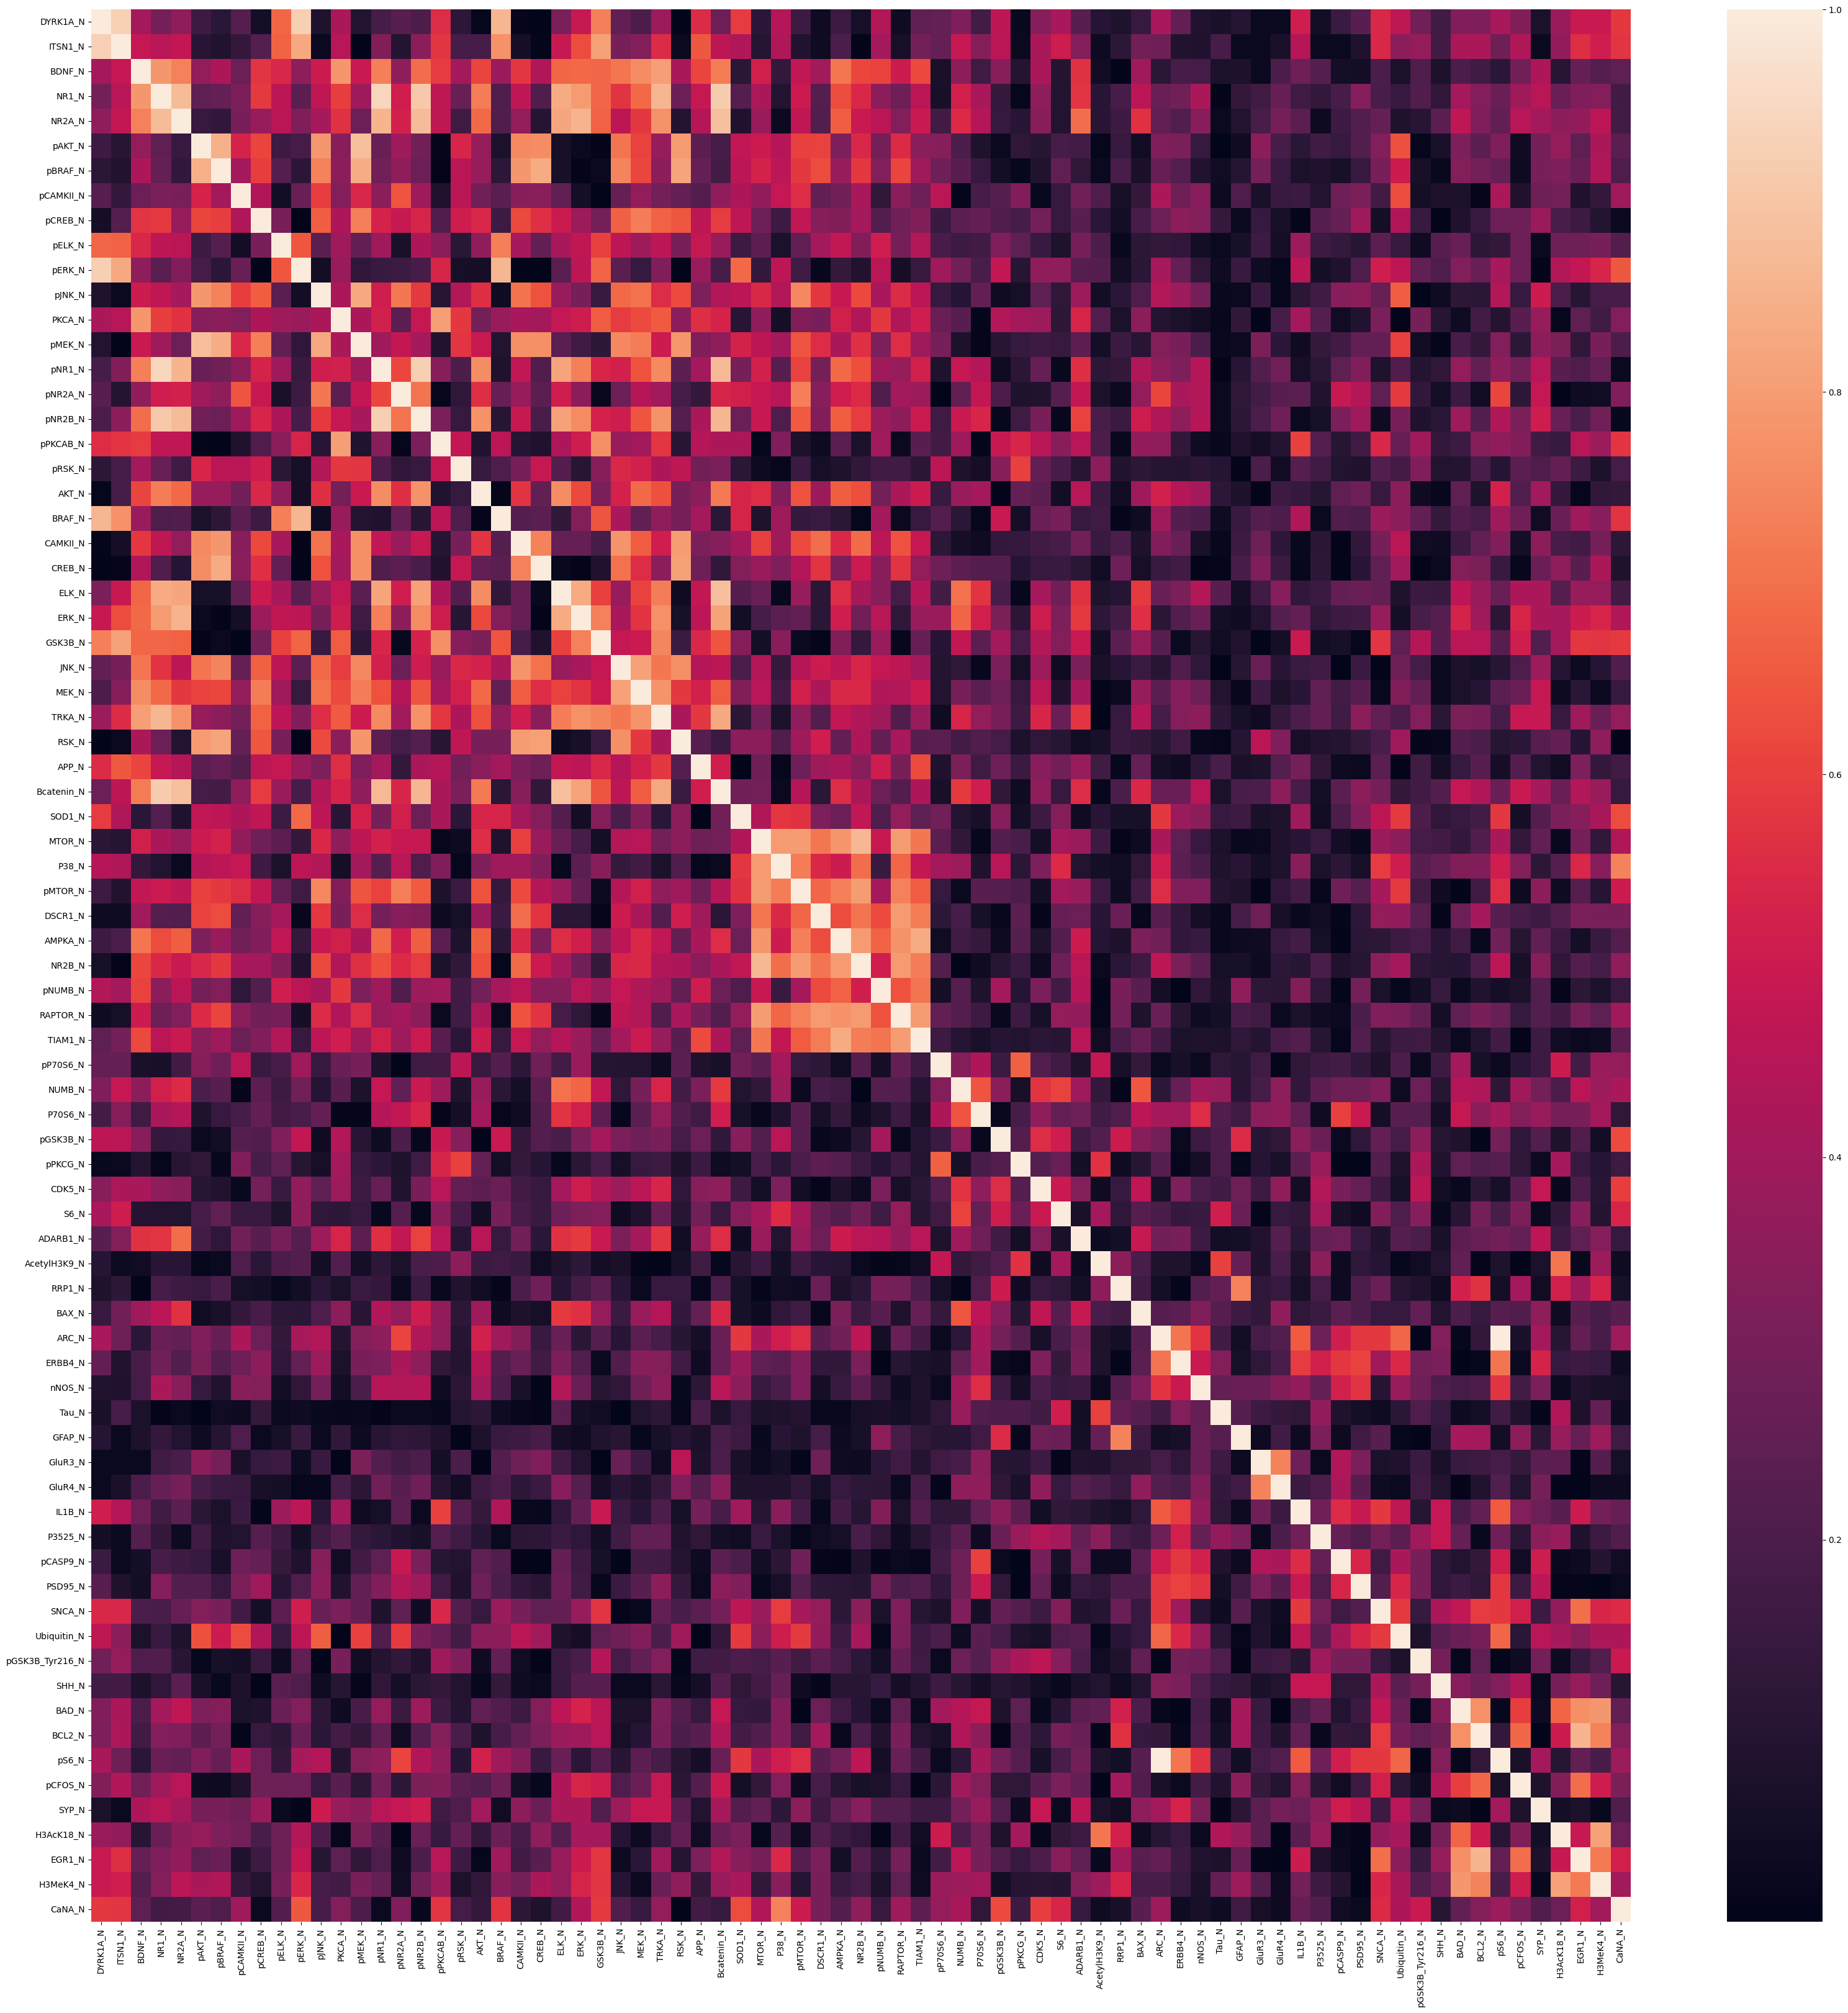

In [ ]:
import seaborn as sns

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(40, 40))

# Calculate correlation matrix using Spearman method for non-linear correlation
corrMatrix = df.corr(method='spearman')

# Plot heatmap of absolute correlation values
sns.heatmap(abs(corrMatrix), annot=False, ax=ax)

# Initialize a set to keep track of highly correlated variables
high_corr_vars = set()

# Iterate over the columns of the correlation matrix
for i, col1 in enumerate(corrMatrix.columns):
    for j, col2 in enumerate(corrMatrix.columns):
        # Ensure we only check the upper triangle of the correlation matrix
        if j > i:
            # Check if the absolute correlation value is greater than 0.8
            if abs(corrMatrix.iloc[i, j]) > 0.8:
                # Add highly correlated variable pairs to the set
                high_corr_vars.add(col1)
                high_corr_vars.add(col2)

# Print highly correlated features
print(f'Highly correlated features: {high_corr_vars}')

# Show the plot
plt.show()


Observations: 36 out of 77 features are highly correlated i.e. correlation index more than 0.8 ans we can thus eliminate these variables.

#2 C



c. Train, validate varying at least one hyperparameter, and test at least two types of models: [2] i. Random forest ii. Support vector classification using RBF kernel iii. Neural network with single hidden layer (output layer should be have softmax activation)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

seed = 42

# Split data into features (x) and target (y)
x = df.drop('class', axis=1)
y = df['class']

# Split data into temporary dataset and holdout dataset (60% train, 40% holdout)
x_train_holdout, x_holdout, y_train_holdout, y_holdout = train_test_split(x, y, test_size=0.2, random_state=seed)

# Split holdout dataset into validation and test datasets (50% validation, 50% test of pending 40%)
x_val, x_test, y_val, y_test = train_test_split(x_holdout, y_holdout, test_size=0.5, random_state=seed)

# Impute missing values in datasets
imp_mean = IterativeImputer(random_state=seed)
x_train = imp_mean.fit_transform(x_train_holdout)
x_val = imp_mean.transform(x_val)
x_test = imp_mean.transform(x_test)

# Normalize x_train
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)

# Transform x_val and x_test using the same scaler
x_val_normalized = scaler.transform(x_val)
x_test_normalized = scaler.transform(x_test)

# Verify the shapes of the resulting sets
print('Training set shape:', x_train_normalized.shape)
print('Validation set shape:', x_val_normalized.shape)
print('Test set shape:', x_test_normalized.shape)


Training set shape: (864, 77)
Validation set shape: (108, 77)
Test set shape: (108, 77)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Define models and hyperparameters
models = {
    "Random Forest": RandomForestClassifier(),
    "SVC with RBF kernel": SVC(kernel='rbf'),
    "Neural Network": MLPClassifier(max_iter=500, activation='logistic')
}

params = {
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "SVC with RBF kernel": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (200,)], "alpha": [0.0001, 0.001, 0.01]}
}

# Train, validate, and test models
for name, model in models.items():
    print(f"Training and tuning {name}...")

    x_train = x_train_normalized
    y_train = y_train_holdout

    # Perform grid search CV for hyperparameter tuning
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    # Get best estimator
    best_model = grid_search.best_estimator_
    models[name] = best_model

    # Train
    y_train_pred = best_model.predict(x_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_acc}")

    # Validate
    y_val_pred = best_model.predict(x_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_acc}")

    # Test
    y_test_pred = best_model.predict(x_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_acc}\n")


Training and tuning Random Forest...
Training Accuracy: 1.0
Validation Accuracy: 0.2222222222222222
Test Accuracy: 0.1388888888888889

Training and tuning SVC with RBF kernel...
Training Accuracy: 1.0
Validation Accuracy: 0.32407407407407407
Test Accuracy: 0.21296296296296297

Training and tuning Neural Network...
Training Accuracy: 1.0
Validation Accuracy: 0.16666666666666666
Test Accuracy: 0.2222222222222222



In [ ]:
from sklearn.inspection import permutation_importance
import shap

# Define a function to calculate feature weights
def feature_weights(y):
    return sorted(zip(df.columns, y / sum(y)), key=lambda x: x[1], reverse=True)

# Calculate feature importances for Random Forest
rf_importances = np.abs(models['Random Forest'].feature_importances_)

# Calculate feature importances for SVC using permutation_importance
svr_coefs = np.abs(permutation_importance(models['SVC with RBF kernel'], x_train, y_train, random_state=seed).importances_mean)

# Calculate feature importances for Neural Network using permutation_importance
nn_coefs = np.abs(permutation_importance(models['Neural Network'], x_train, y_train, random_state=seed).importances_mean)

# Print Random Forest Feature Importances
print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
    print(f"{i}: {importance}")

# Print SVC Feature Importances
print("\nSVC Feature Importances:")
for i, importance in feature_weights(svr_coefs):
    print(f"{i}: {importance}")


Random Forest Feature Importances:
SOD1_N: 0.062054847695175774
pERK_N: 0.036699579981619636
pPKCG_N: 0.0323092900179398
APP_N: 0.03097497027420254
CaNA_N: 0.03091807146472226
DYRK1A_N: 0.029816692358513735
pCAMKII_N: 0.027085726835517812
ITSN1_N: 0.027059816079010212
ARC_N: 0.024925657403181856
BRAF_N: 0.02451219862665777
Tau_N: 0.024026171877927577
pP70S6_N: 0.023444754040477335
Ubiquitin_N: 0.023297224426421275
pPKCAB_N: 0.022862382690993114
S6_N: 0.021152817223682018
P38_N: 0.0205781962045895
pNUMB_N: 0.020282211065510952
pS6_N: 0.020027698355937568
AcetylH3K9_N: 0.01780076648655007
AKT_N: 0.017477808398854582
pGSK3B_N: 0.0166675667647671
pMTOR_N: 0.015939425657147902
nNOS_N: 0.01326655428592296
RAPTOR_N: 0.012828937807161583
IL1B_N: 0.011967342676630563
MTOR_N: 0.011452865705620634
PKCA_N: 0.01138451794112919
ADARB1_N: 0.011049099141699364
CAMKII_N: 0.01104839692262026
pNR2A_N: 0.010957156302347275
pJNK_N: 0.01072467706823967
H3AcK18_N: 0.010511675734742031
NR2B_N: 0.0104646644063

#2 D


d. See if removing some features systematically will improve your models using recursive feature elimination https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). [1]

In [ ]:
from sklearn.feature_selection import RFECV

# Define the model
selected_model = models['Random Forest']

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=selected_model, step=0.5, scoring='accuracy')
rfecv.fit(x_train, y_train)

# Print the optimal number of features and selected features
print(f"\nOptimal number of features for {name}: {rfecv.n_features_}")
selected_features = np.array(x.columns)[rfecv.support_]
print(f"Selected features for {name}:\n{selected_features}")

# Transform training data to selected features
x_train_selected = rfecv.transform(x_train)
selected_model.fit(x_train_selected, y_train)

# Train
y_train_pred = selected_model.predict(rfecv.transform(x_train))
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc}")

# Validate
y_val_pred = selected_model.predict(rfecv.transform(x_val))
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc}")

# Test
y_test_pred = selected_model.predict(rfecv.transform(x_test))
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc}\n")

feature_weights=lambda y:sorted(zip(df.columns, y/sum(y)), key=lambda x:x[1], reverse=True)
rf_importances=np.abs(models['Random Forest'].feature_importances_)#check importance again

print("Random Forest Feature Importances:")
for i, importance in feature_weights(rf_importances):
  print(f"{i}:{importance}")



Optimal number of features for Neural Network: 39
Selected features for Neural Network:
['DYRK1A_N' 'ITSN1_N' 'pCAMKII_N' 'pERK_N' 'pJNK_N' 'PKCA_N' 'pNR2A_N'
 'pPKCAB_N' 'AKT_N' 'BRAF_N' 'CAMKII_N' 'APP_N' 'SOD1_N' 'MTOR_N' 'P38_N'
 'pMTOR_N' 'DSCR1_N' 'pNUMB_N' 'RAPTOR_N' 'pP70S6_N' 'NUMB_N' 'pGSK3B_N'
 'pPKCG_N' 'S6_N' 'ADARB1_N' 'AcetylH3K9_N' 'RRP1_N' 'ARC_N' 'ERBB4_N'
 'nNOS_N' 'Tau_N' 'IL1B_N' 'P3525_N' 'SNCA_N' 'Ubiquitin_N' 'pS6_N'
 'SYP_N' 'H3AcK18_N' 'CaNA_N']
Training Accuracy: 1.0
Validation Accuracy: 0.1574074074074074
Test Accuracy: 0.12962962962962962

Random Forest Feature Importances:
PKCA_N:0.07590031382147257
CREB_N:0.047575207411507316
NR2B_N:0.044989388086209246
NR1_N:0.042741201150323566
pJNK_N:0.04239967017743891
BDNF_N:0.03841025437437766
ITSN1_N:0.03288294596707416
pCAMKII_N:0.03276668025650687
DYRK1A_N:0.03177949691394604
P38_N:0.03037564246730938
APP_N:0.03036395301399946
pELK_N:0.029891256745777556
MEK_N:0.02940687566822948
pMTOR_N:0.027889446708810214
ELK

Observation: My model's accuracy remains unchanged even after shrinking the input feature size from 77 to 39, or a 50% reduction, suggesting that those features were superfluous. Model complexity is being reduced by 50% while accuracy ratings remain unchanged.

#3 Practice using pre-trained neural networks to extract domain-specific features for new tasks

#3 A


a. Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore “finetuning the ConvNet”. Test this code out to see if it runs properly in your environment after eliminating code blocks that you do not need. [1]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark=True

#downloadng and extracting dataset
!rm -rf hymenoptera_data
!wget -q https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -q hymenoptera_data.zip
! rm -rf hymenoptera_data.zip

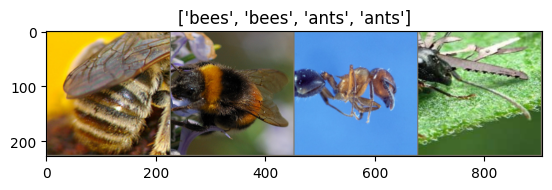

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets

# Setting up train and val transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.484, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Using code from given documentation
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Displaying image
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Display the grid of images
imshow(out, title=[class_names[x] for x in classes])


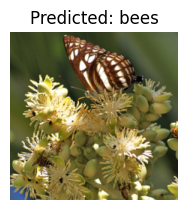

In [ ]:
# Load the pre-trained ResNet18 model from torchvision
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze parameters to avoid training them
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the fully connected layer with a new linear layer for binary classification
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

# Function to visualize model predictions on an image
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    # Open and transform the image
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # Display the image and predicted class
        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        # Restore model training mode
        model.train(mode=was_training)

# Visualize predictions for an example image
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

# Disable interactive plotting and display the plot
plt.ioff()
plt.show()


#3 B


b. Write a function that outputs ResNet18 features for a given input image. Extract features for training images (in image_datasets['train']). You should get an Nx512 dimensional array. [1]

In [ ]:
# Importing required libraries
from torchvision import transforms, datasets
import torch
import os

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.484, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define data directory
data_directory = 'hymenoptera_data'

# Create datasets for train and validation
image_datasets = {split: datasets.ImageFolder(os.path.join(data_directory, split),
                                              transform=data_transforms[split])
                  for split in ['train', 'val']}

# Create data loaders for train and validation
data_loaders = {split: torch.utils.data.DataLoader(image_datasets[split], batch_size=4,
                                                   shuffle=True, num_workers=2)
                for split in ['train', 'val']}

# Calculate dataset sizes for train and validation
dataset_sizes = {split: len(image_datasets[split]) for split in ['train', 'val']}

# Get class names
class_names = image_datasets['train'].classes

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
from torchvision import models
import torch
import numpy as np

# Define device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_pretrained_resnet18():
    """Load pre-trained ResNet18 model."""
    # Load pre-trained ResNet18 model
    resnet_model = models.resnet18(pretrained=True)

    # Set model to evaluation mode
    resnet_model.eval()

    return resnet_model

def extract_features(model, dataloader):
    """Extract features using the provided model and dataloader."""
    features_list, labels_list = [], []

    # Iterate over batches in the dataloader
    for inputs, labels_batch in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            # Forward pass through the model
            features_batch = model(inputs).detach().cpu().numpy()  # Detach and convert to numpy
        features_list.append(features_batch)
        labels_list.append(labels_batch.numpy())

    # Concatenate features and labels
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return features, labels

# Load pre-trained ResNet18 model
resnet_model = load_pretrained_resnet18()

# Extract features for training and validation sets
train_features, train_labels = extract_features(resnet_model, dataloaders['train'])
val_features, val_labels = extract_features(resnet_model, dataloaders['val'])

# Optional: Feature selection (consider PCA or feature importance)
# train_features = train_features[:, :512]  # Select only the first 512 features (replace with selection method)
# val_features = val_features[:, :512]

# Print dimensions of extracted features
print('Dimensions of train extracted features:', train_features.shape)
print('Dimensions of validation extracted features:', val_features.shape)


Dimensions of train extracted features: (244, 1000)
Dimensions of validation extracted features: (153, 1000)


#3 C


c. Compare RBF kernel SVM (do grid search on kernel width and regularization) and random forest (do grid search on max depth and number of trees). Test the final model on test data and show the results -- accuracy and F1 score. [1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

def perform_grid_search(model, param_grid, x_train, y_train):
    """Perform grid search for the given model."""
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def train_model_with_best_params(model, best_params, x_train, y_train):
    """Train the model with the best hyperparameters."""
    best_model = model.set_params(**best_params)
    best_model.fit(x_train, y_train)
    return best_model



def evaluate_model(model, x_test, y_test):
    """Evaluate the model on test data."""
    test_preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, test_preds)
    # Calculate F1 score for multiclass classification
    f1 = f1_score(y_test, test_preds, average='weighted')
    return accuracy, f1


# Define parameter grids for grid search
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
rf_param_grid = {'max_depth': [None, 10, 20], 'n_estimators': [50, 100, 200]}

# Perform grid search for SVM
best_svm_params = perform_grid_search(SVC(kernel='rbf'), svm_param_grid, x_train, y_train)

# Perform grid search for Random Forest
best_rf_params = perform_grid_search(RandomForestClassifier(), rf_param_grid, x_train, y_train)

# Train SVM and Random Forest models with best hyperparameters
best_svm_model = train_model_with_best_params(SVC(kernel='rbf'), best_svm_params, x_train, y_train)
best_rf_model = train_model_with_best_params(RandomForestClassifier(), best_rf_params, x_train, y_train)

# Evaluate SVM and Random Forest models
svm_accuracy, svm_f1_score = evaluate_model(best_svm_model, x_test, y_test)
rf_accuracy, rf_f1_score = evaluate_model(best_rf_model, x_test, y_test)

# Print evaluation metrics
print("SVM Accuracy: ", svm_accuracy)
print("Random Forest Accuracy: ", rf_accuracy)
print("SVM F1 Score: ", svm_f1_score)
print("Random Forest F1 Score: ", rf_f1_score)


SVM Accuracy:  0.1111111111111111
Random Forest Accuracy:  0.14814814814814814
SVM F1 Score:  0.022222222222222223
Random Forest F1 Score:  0.05038267758932348
